In [1]:
pip install snntorch

In [2]:
# imports
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt

In [3]:
# LIF神经元模型，它需要加权输入的总和，就像人工神经元一样。
# 但它不会将其直接传递给激活函数，而随着时间的推移将输入与泄漏进行积分，就像 RC 电路一样
# snnTorch目前支持的LIF模型
# Lapicque’s RC model: snntorch.Lapicque
# 1st-order model: snntorch.Leaky
# Synaptic Conductance-based neuron model: snntorch.Synaptic
# Recurrent 1st-order model: snntorch.RLeaky
# Recurrent Synaptic Conductance-based neuron model: snntorch.RSynaptic
# Alpha neuron model: snntorch.Alpha


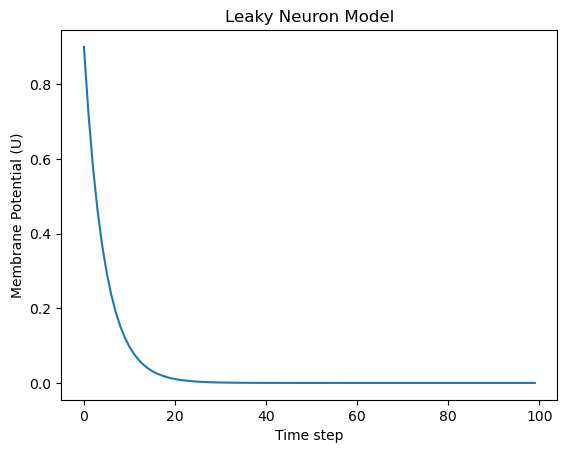

In [7]:
# Forward Euler Method to Solving the LIF Neuron Model
# 默认值设置R = 50MΩ,C = 100pF, tau = 5ms,这些对于神经元来说是非常现实的
def leaky_integrate_neuron(U, time_step=1e-3, I=0, R=5e7, C=1e-10):
  tau = R * C
  U = U + (time_step / tau) * (-U + I * R)
  return U

def plot_mem(U_trace, title):
    plt.plot(U_trace)
    plt.title(title)
    plt.xlabel('Time step')
    plt.ylabel('Membrane Potential (U)')
    plt.show()

num_steps = 100
U = 0.9
U_trace = []  # keeps a record of U for plotting

for step in range(num_steps):
  U_trace.append(U)
  U = leaky_integrate_neuron(U)  # solve next step of U

plot_mem(U_trace, "Leaky Neuron Model")

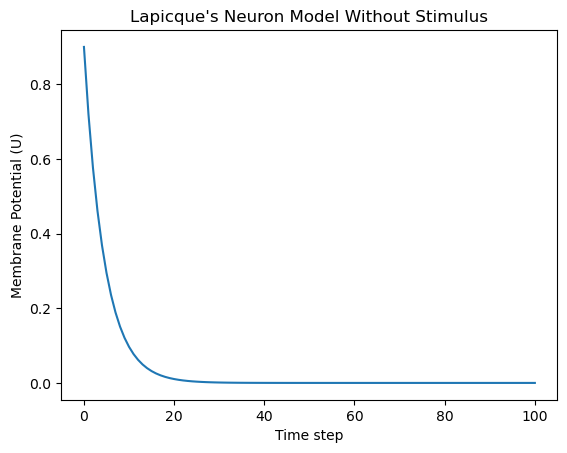

In [8]:
# Lapicque’s LIF Neuron Model
# 1. 没有刺激的情况下

# 神经元模型现在存储在lif1. 要使用这个神经元
time_step = 1e-3
R = 5
C = 1e-3

# leaky integrate and fire neuron, tau=5e-3
lif1 = snn.Lapicque(R=R, C=C, time_step=time_step)

# Initialize membrane, input, and output
mem = torch.ones(1) * 0.9  # U=0.9 at t=0
cur_in = torch.zeros(num_steps)  # I=0 for all t
spk_out = torch.zeros(1)  # initialize output spikes

# A list to store a recording of membrane potential
mem_rec = [mem]

# pass updated value of mem and cur_in[step]=0 at every time step
for step in range(num_steps):
  spk_out, mem = lif1(cur_in[step], mem)

  # Store recordings of membrane potential
  mem_rec.append(mem)

# convert the list of tensors into one tensor
mem_rec = torch.stack(mem_rec)

# pre-defined plotting function
plot_mem(mem_rec, "Lapicque's Neuron Model Without Stimulus")


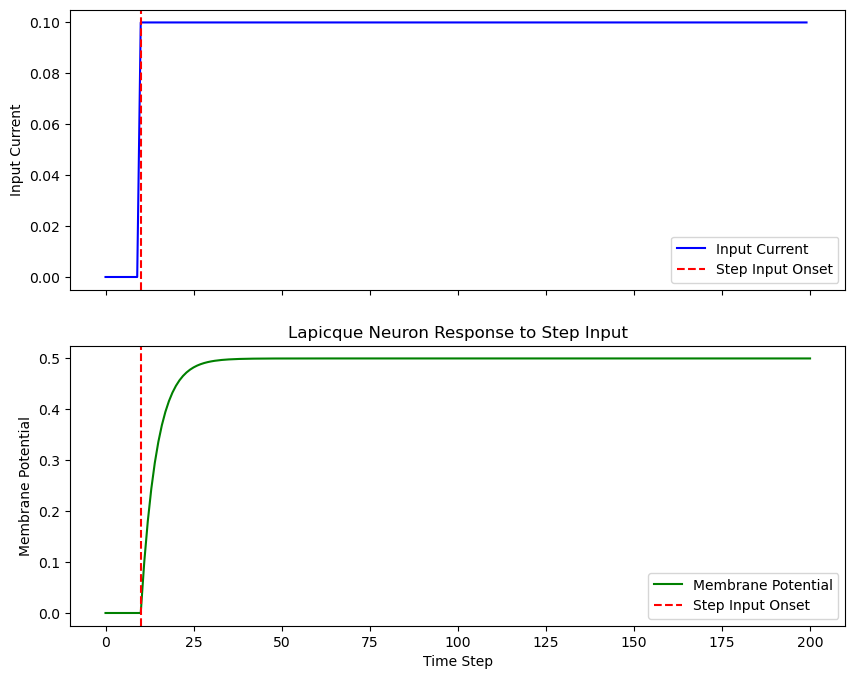

In [11]:
def plot_step_current_response(input_current, membrane_potential, step_time):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    ax1.plot(input_current, label='Input Current', color='b')
    ax1.axvline(x=step_time, color='r', linestyle='--', label='Step Input Onset')
    ax1.set_ylabel('Input Current')
    ax1.legend()

    ax2.plot(membrane_potential, label='Membrane Potential', color='g')
    ax2.axvline(x=step_time, color='r', linestyle='--', label='Step Input Onset')
    ax2.set_xlabel('Time Step')
    ax2.set_ylabel('Membrane Potential')
    ax2.legend()

    plt.title('Lapicque Neuron Response to Step Input')
    plt.show()

# Initialize input current pulse
cur_in = torch.cat((torch.zeros(10), torch.ones(190)*0.1), 0)  # input current turns on at t=10

# Initialize membrane, output and recordings
mem = torch.zeros(1)  # membrane potential of 0 at t=0
spk_out = torch.zeros(1)  # neuron needs somewhere to sequentially dump its output spikes
mem_rec = [mem]

num_steps = 200

# pass updated value of mem and cur_in[step] at every time step
for step in range(num_steps):
  spk_out, mem = lif1(cur_in[step], mem)
  mem_rec.append(mem)

# crunch -list- of tensors into one tensor
mem_rec = torch.stack(mem_rec)

plot_step_current_response(cur_in, mem_rec, 10)

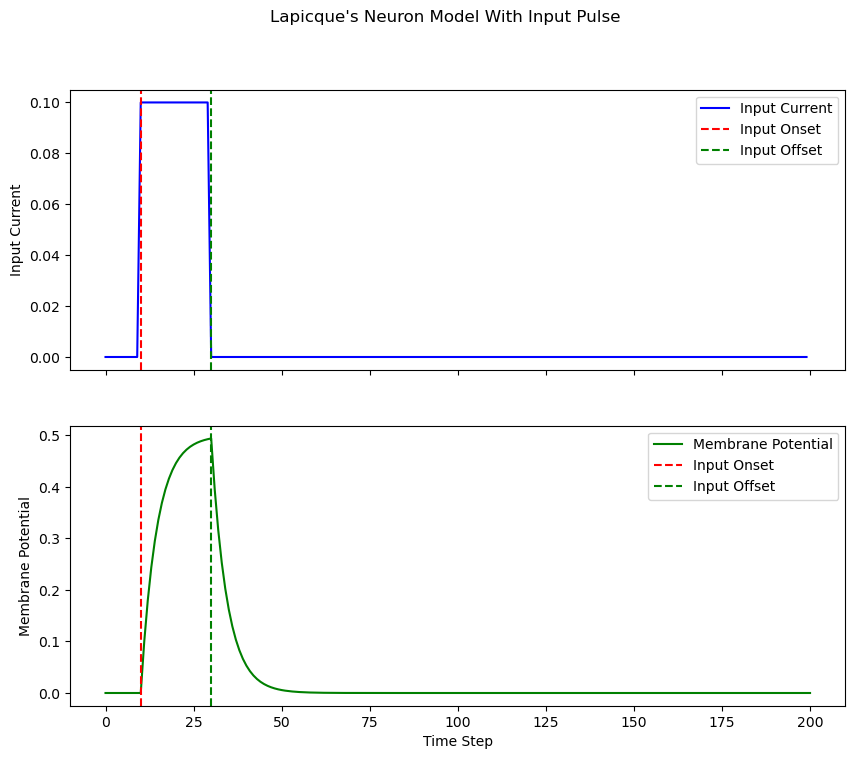

In [13]:
# the step input was clipped at 30ms
# Initialize current pulse, membrane and outputs
# conclusion: U就像阶跃输入一样上升，但现在它以时间常数衰减就像我们的第一次模拟一样。

def plot_current_pulse_response(input_current, membrane_potential, title, vline1, vline2):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    ax1.plot(input_current, label='Input Current', color='b')
    ax1.axvline(x=vline1, color='r', linestyle='--', label='Input Onset')
    ax1.axvline(x=vline2, color='g', linestyle='--', label='Input Offset')
    ax1.set_ylabel('Input Current')
    ax1.legend()

    ax2.plot(membrane_potential, label='Membrane Potential', color='g')
    ax2.axvline(x=vline1, color='r', linestyle='--', label='Input Onset')
    ax2.axvline(x=vline2, color='g', linestyle='--', label='Input Offset')
    ax2.set_xlabel('Time Step')
    ax2.set_ylabel('Membrane Potential')
    ax2.legend()

    plt.suptitle(title)
    plt.show()

cur_in1 = torch.cat((torch.zeros(10), torch.ones(20)*(0.1), torch.zeros(170)), 0)  # input turns on at t=10, off at t=30
mem = torch.zeros(1)
spk_out = torch.zeros(1)
mem_rec1 = [mem]

# neuron simulation
for step in range(num_steps):
  spk_out, mem = lif1(cur_in1[step], mem)
  mem_rec1.append(mem)
mem_rec1 = torch.stack(mem_rec1)

plot_current_pulse_response(cur_in1, mem_rec1, "Lapicque's Neuron Model With Input Pulse",
                            vline1=10, vline2=30)

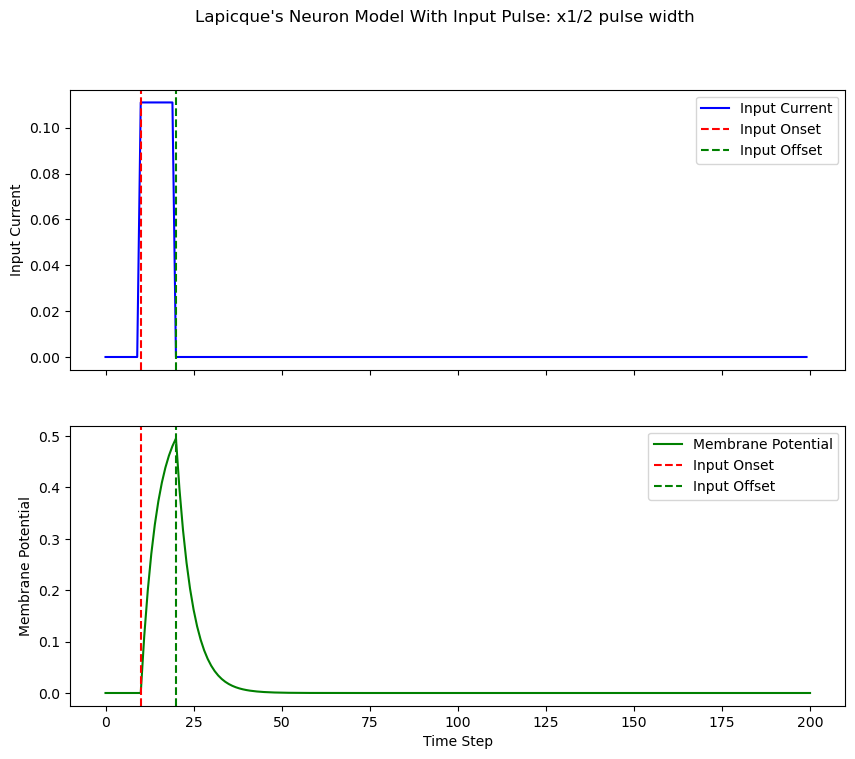

In [14]:
# Increase amplitude of current pulse; half the time.
cur_in2 = torch.cat((torch.zeros(10), torch.ones(10)*0.111, torch.zeros(180)), 0)  # input turns on at t=10, off at t=20
mem = torch.zeros(1)
spk_out = torch.zeros(1)
mem_rec2 = [mem]

# neuron simulation
for step in range(num_steps):
  spk_out, mem = lif1(cur_in2[step], mem)
  mem_rec2.append(mem)
mem_rec2 = torch.stack(mem_rec2)

plot_current_pulse_response(cur_in2, mem_rec2, "Lapicque's Neuron Model With Input Pulse: x1/2 pulse width",
                            vline1=10, vline2=20)

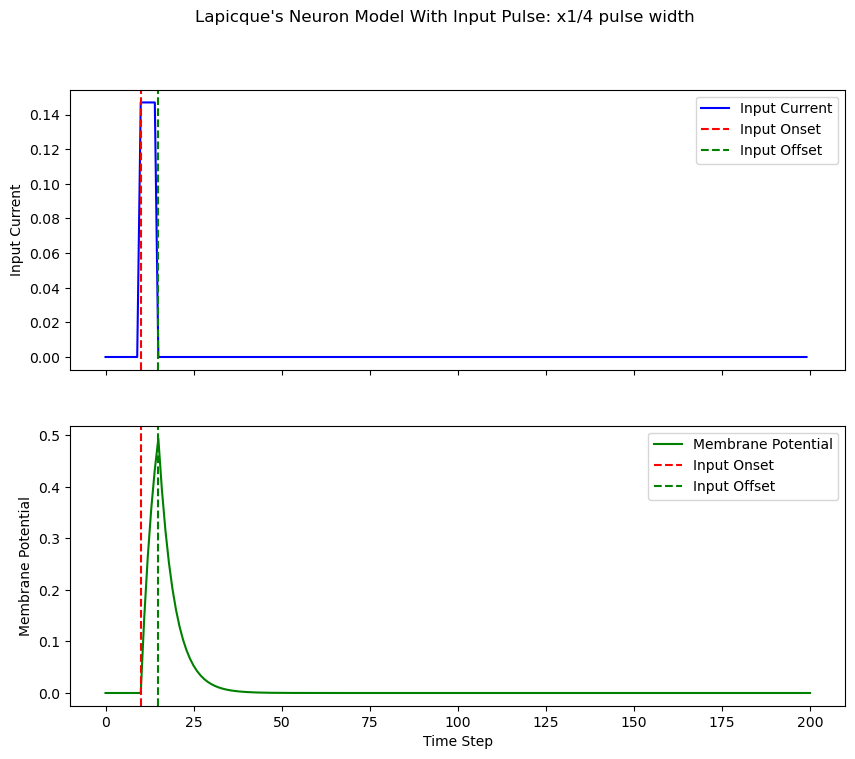

In [15]:
# Increase amplitude of current pulse; quarter the time.
cur_in3 = torch.cat((torch.zeros(10), torch.ones(5)*0.147, torch.zeros(185)), 0)  # input turns on at t=10, off at t=15
mem = torch.zeros(1)
spk_out = torch.zeros(1)
mem_rec3 = [mem]

# neuron simulation
for step in range(num_steps):
  spk_out, mem = lif1(cur_in3[step], mem)
  mem_rec3.append(mem)
mem_rec3 = torch.stack(mem_rec3)

plot_current_pulse_response(cur_in3, mem_rec3, "Lapicque's Neuron Model With Input Pulse: x1/4 pulse width",
                            vline1=10, vline2=15)

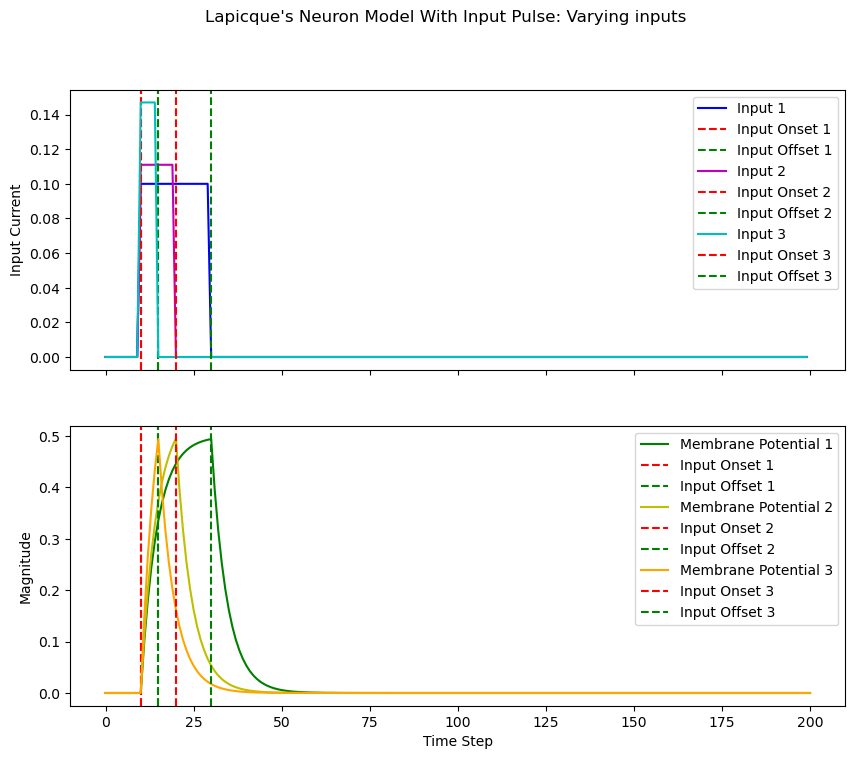

In [18]:
def compare_plots(cur_in1, cur_in2, cur_in3, mem_rec1, mem_rec2, mem_rec3, vline1, vline2, vline3, vline4, title):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    ax1.plot(cur_in1, label='Input 1', color='b')
    ax1.axvline(x=vline1, color='r', linestyle='--', label='Input Onset 1')
    ax1.axvline(x=vline2, color='g', linestyle='--', label='Input Offset 1')
    ax1.set_ylabel('Input Current')
    ax1.legend()

    ax1.plot(cur_in2, label='Input 2', color='m')
    ax1.axvline(x=vline1, color='r', linestyle='--', label='Input Onset 2')
    ax1.axvline(x=vline2, color='g', linestyle='--', label='Input Offset 2')
    ax1.legend()

    ax1.plot(cur_in3, label='Input 3', color='c')
    ax1.axvline(x=vline3, color='r', linestyle='--', label='Input Onset 3')
    ax1.axvline(x=vline4, color='g', linestyle='--', label='Input Offset 3')
    ax1.legend()

    ax2.plot(mem_rec1, label='Membrane Potential 1', color='g')
    ax2.axvline(x=vline1, color='r', linestyle='--', label='Input Onset 1')
    ax2.axvline(x=vline2, color='g', linestyle='--', label='Input Offset 1')

    ax2.plot(mem_rec2, label='Membrane Potential 2', color='y')
    ax2.axvline(x=vline1, color='r', linestyle='--', label='Input Onset 2')
    ax2.axvline(x=vline2, color='g', linestyle='--', label='Input Offset 2')

    ax2.plot(mem_rec3, label='Membrane Potential 3', color='orange')
    ax2.axvline(x=vline3, color='r', linestyle='--', label='Input Onset 3')
    ax2.axvline(x=vline4, color='g', linestyle='--', label='Input Offset 3')

    ax2.set_xlabel('Time Step')
    ax2.set_ylabel('Magnitude')
    ax2.legend()

    plt.suptitle(title)
    plt.show()


compare_plots(cur_in1, cur_in2, cur_in3, mem_rec1, mem_rec2, mem_rec3, 10, 15,
              20, 30, "Lapicque's Neuron Model With Input Pulse: Varying inputs")

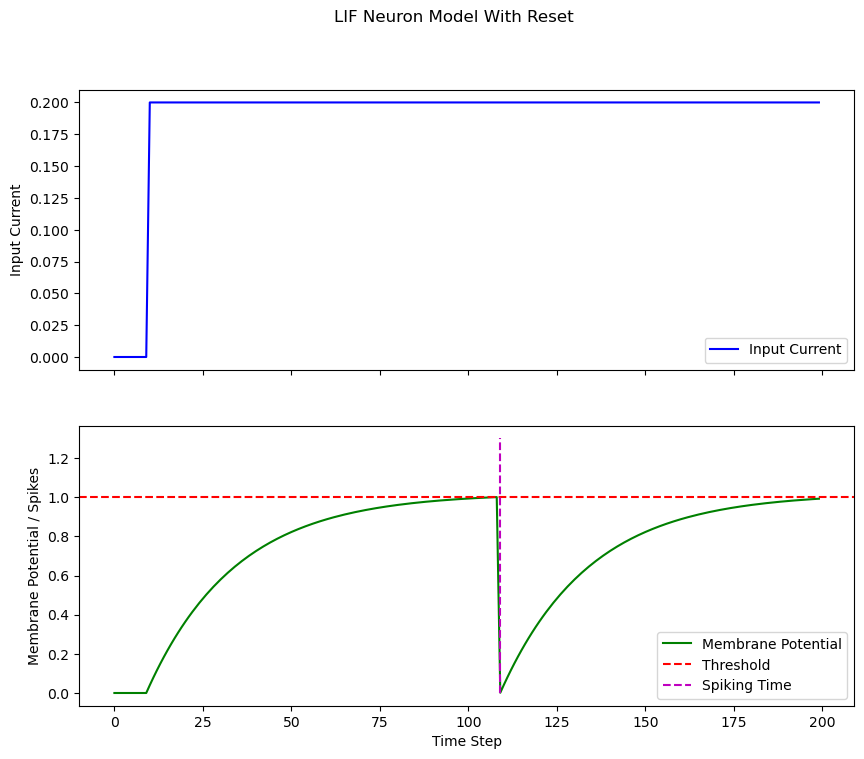

In [20]:
# LIF w/Reset mechanism
def leaky_integrate_and_fire(mem, cur=0, threshold=1, time_step=1e-3, R=5.1, C=5e-3):
  tau_mem = R*C
  spk = (mem > threshold)
  mem = mem + (time_step/tau_mem)*(-mem + cur*R) - spk*threshold  # every time spk=1, subtract the threhsold
  return mem, spk

def plot_cur_mem_spk(cur_in, mem_rec, spk_rec, thr_line, vline, ylim_max2, title):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    ax1.plot(cur_in, label='Input Current', color='b')
    ax1.set_ylabel('Input Current')
    ax1.legend()

    ax2.plot(mem_rec, label='Membrane Potential', color='g')
    ax2.axhline(y=thr_line, color='r', linestyle='--', label='Threshold')
    ax2.vlines(x=vline, ymin=0, ymax=ylim_max2, color='m', linestyle='--', label='Spiking Time')
    ax2.set_xlabel('Time Step')
    ax2.set_ylabel('Membrane Potential / Spikes')
    ax2.legend()

    plt.suptitle(title)
    plt.show()

# Small step current input
cur_in = torch.cat((torch.zeros(10), torch.ones(190)*0.2), 0)
mem = torch.zeros(1)
mem_rec = []
spk_rec = []

# neuron simulation
for step in range(num_steps):
  mem, spk = leaky_integrate_and_fire(mem, cur_in[step])
  mem_rec.append(mem)
  spk_rec.append(spk)

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

plot_cur_mem_spk(cur_in, mem_rec, spk_rec, thr_line=1, vline=109, ylim_max2=1.3,
                 title="LIF Neuron Model With Reset")

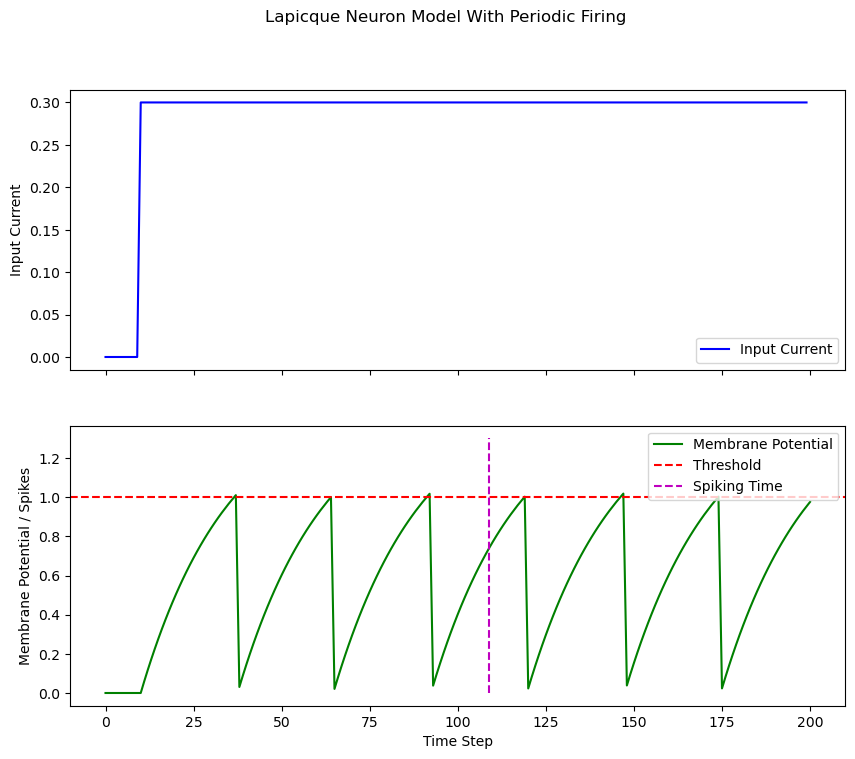

In [23]:
# Initialize inputs and outputs
cur_in = torch.cat((torch.zeros(10), torch.ones(190)*0.3), 0)  # increased current
mem = torch.zeros(1)
spk_out = torch.zeros(1)
mem_rec = [mem]
spk_rec = [spk_out]

lif2 = snn.Lapicque(R=5.1, C=5e-3, time_step=1e-3)

# neuron simulation
for step in range(num_steps):
  spk_out, mem = lif2(cur_in[step], mem)
  mem_rec.append(mem)
  spk_rec.append(spk_out)

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)


plot_cur_mem_spk(cur_in, mem_rec, spk_rec, thr_line=1,vline=109, ylim_max2=1.3,
                 title="Lapicque Neuron Model With Periodic Firing")


There are 72 total spikes out of 200 time steps.


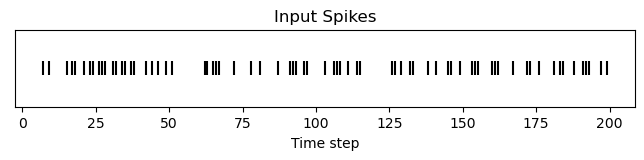

In [24]:
# 随机生成的输入尖峰,来看看产生的输入尖峰

# Create a 1-D random spike train. Each element has a probability of 40% of firing.
spk_in = spikegen.rate_conv(torch.ones((num_steps)) * 0.40)
print(f"There are {int(sum(spk_in))} total spikes out of {len(spk_in)} time steps.")

fig = plt.figure(facecolor="w", figsize=(8, 1))
ax = fig.add_subplot(111)

splt.raster(spk_in.reshape(num_steps, -1), ax, s=100, c="black", marker="|")
plt.title("Input Spikes")
plt.xlabel("Time step")
plt.yticks([])
plt.show()

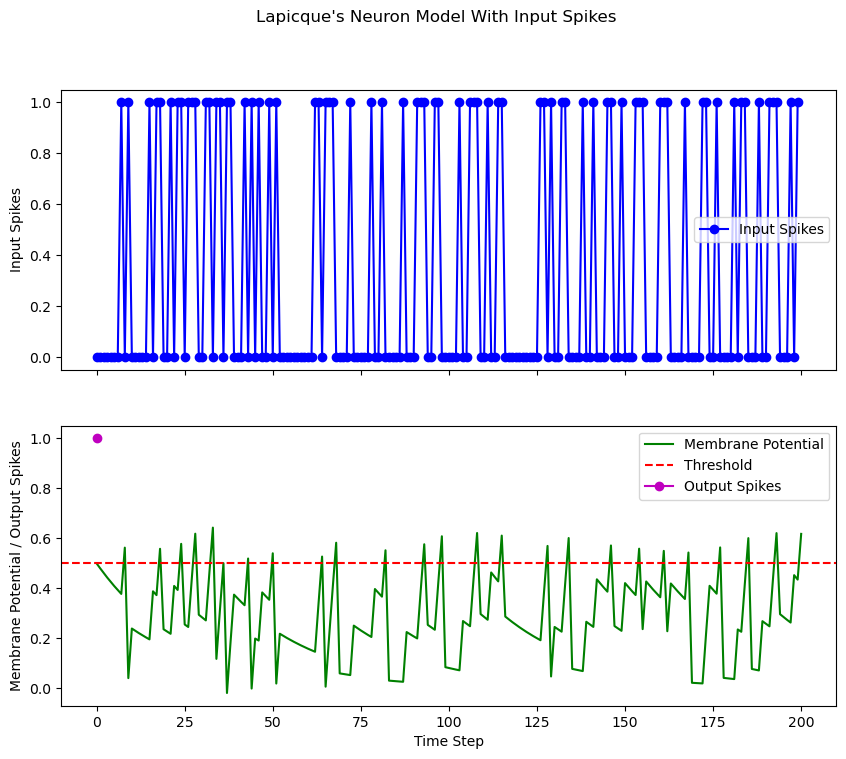

In [27]:
def plot_spk_mem_spk(spk_in, mem_rec, spk_out, title):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    ax1.plot(spk_in, label='Input Spikes', color='b', marker='o')
    ax1.set_ylabel('Input Spikes')
    ax1.legend()

    ax2.plot(mem_rec, label='Membrane Potential', color='g')
    ax2.axhline(y=lif3.threshold, color='r', linestyle='--', label='Threshold')
    ax2.plot(spk_out, label='Output Spikes', color='m', marker='o')
    ax2.set_xlabel('Time Step')
    ax2.set_ylabel('Membrane Potential / Output Spikes')
    ax2.legend()

    plt.suptitle(title)
    plt.show()

lif3 = snn.Lapicque(R=5.1, C=5e-3, time_step=1e-3, threshold=0.5)

# Initialize inputs and outputs
mem = torch.ones(1)*0.5
spk_out = torch.zeros(1)
mem_rec = [mem]
spk_rec = [spk_out]

# Neuron simulation
for step in range(num_steps):
  spk_out, mem = lif3(spk_in[step], mem)
  spk_rec.append(spk_out)
  mem_rec.append(mem)

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

plot_spk_mem_spk(spk_in, mem_rec, spk_out, "Lapicque's Neuron Model With Input Spikes")